# Open and Crop Landsat RS Data

### Landsat file naming convention

Landsat and many other satellite RS data is named in a way that tells you about:
- When the data were collected and processed
- What sensor was used to collect the data
- What satellite was used to collect the data

There are a few key components of the LS8 collection file name. The 1st scene that you wok with below is named:

LC080340322016072301T1-SC20180214145802

At the start of the name, you see LC08:
- L: Landsat Sensor
- C: OLI/TIRS combined platform
- 08: LS8
- 034032: The next 6 digits represent the path and row of the scene. This identifies the spatial converage of the scene

Finally, you have a date. In your case as follows:
- 20160723: representing the ymd that the data were collected-

The 2nd part oif the file name above tells you more about when the data were last processed.

## Open LS .tif files

In [2]:
import os
from glob import glob # File manipulation
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Download data and set work dir
data = et.data.get_data("cold-springs-fire")
os.chdir(os.path.join(et.io.HOME, "earth-analytics", "data"))

You will be working in the landsat-collect dir. Notice that the data in that directory are stored by individual band. Each file is a single geotiff (.tif) rather than 1 tif with all the bands which is what you worked with in the previous lesson with NAIP data.

### Why are LS bands stored as individual files?

Originally LS was stored in a file format called HDF - Hierarchical Data Format. However that format, while extremely efficient, is a bit more challenging to work with. In recent years, USGS has started to make each band of a LS scene available as a .tif file. This makes it a bit easier to use across many different programs and platforms.

## Generate a list of files in python

To begin, explore the LS files in your cs-test-landsat dir. Start with the data:

data/cs-test-landsat/

LS scenes are large. In order to make the process more efficient, you need to crop all of the data in your LS scenes to be the size of our study area. You will be using crop_all().

You will do the following:
1. You will generate a list of all files in the dir that contain the word band in the name.
2. Crop all layers in that list to the extent of the study area.
3. Stack all the layers into 1 numpy array.

You will use the glob() function and library to do this in Python.

Begin exploring glob() by grabbing everything in the dir using /*.

In [3]:
landsat_post_fire_path = os.path.join("cold-springs-fire",
                                     "landsat_collect",
                                       "LC080340322016072301T1-SC20180214145802",
                                      "crop")

glob(os.path.join(landsat_post_fire_path, "*"))

['cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_pixel_qa_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_radsat_qa_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_aerosol_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_0

### Grab subsets of file names using the file names and other criteria

Above you generated a list of all files in the dir. however, you may want to subset that list to only include:
1. .tif files
2. .tif files that contain the word "band" in them

Note that it si important the file ends with .tif. So we use an asterisk at the end of the path to tell Python to only grab files that end with .tif.

path/*.tif will grab all files in the crop directory that end with the .tif extension.

In [4]:
glob(os.path.join(landsat_post_fire_path, "*.tif"))

['cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_pixel_qa_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_radsat_qa_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_aerosol_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_0

To only grab files containing the word band AND that end with .tif we use *band*.tif. This tells python to look for the word band anywhere before the .tif extension AND anywhere within the file name.

In [5]:
all_landsat_post_bands = glob(os.path.join(
    landsat_post_fire_path, "*band*.tif"))

all_landsat_post_bands

['cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T

Be sure that your bands are in order starting at 1 and ending at 7! If the data are not in order, you can use the .sort() list method to sort your list alphabetically. THe data in this lesson are sorted properly; however, we have noticed that this sort doesn'T happen by default on some machines. The code below will sort your list.

In [6]:
all_landsat_post_bands.sort()
all_landsat_post_bands

['cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop.tif',
 'cold-springs-fire\\landsat_collect\\LC080340322016072301T1-SC20180214145802\\crop\\LC08_L1TP_034032_20160723_20180131_01_T

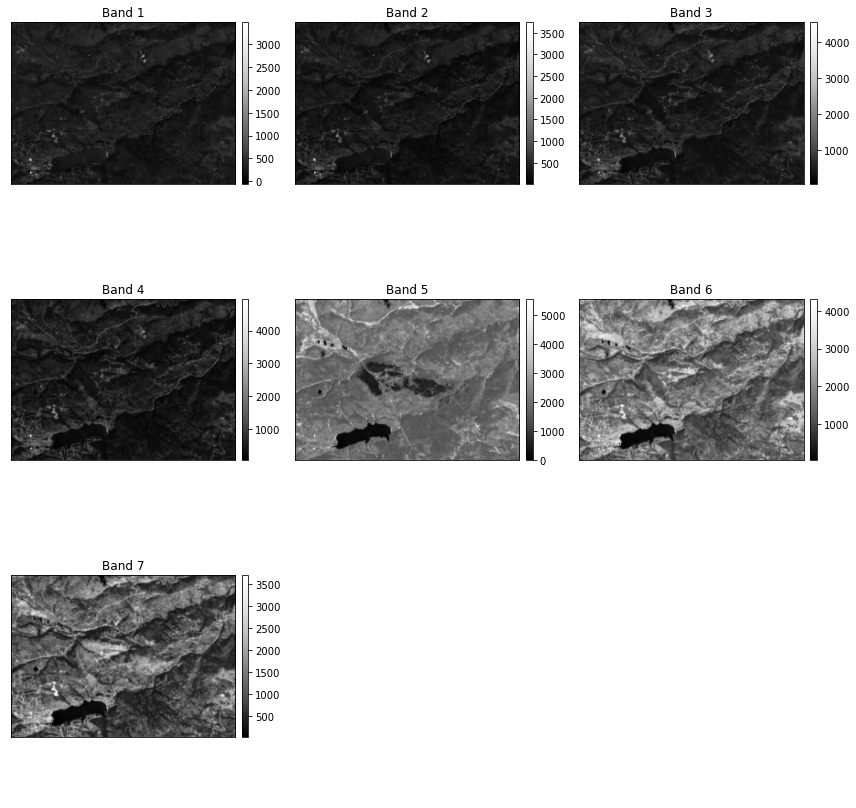

In [7]:
# Stacking
landsat_post_arr, landsat_post_meta = es.stack(all_landsat_post_bands)
ep.plot_bands(landsat_post_arr)

plt.show()

### Crop a single LS band using Earthpy crop_image()

Above you opened up the data and plotted. But sometimes you want to crop your data to just your study area - removing some of the data that you don't need in your analysis. You could choose to open and crop each file individually using the rio.ioen() function alongside with earthpy es.crop_image() function as shown below.

In order to crop a band, you need to have a 
1. geopandas or shapely object that represents the extent of the area you want to study in the LS image (your crop extent).
2. The crop extent shapefile and the LS data need to be in the same CRS.

Below you crop a single band - band 4 of your data. Remember that Python uses 0 based indexing so band 4 is actually at index [3].

C:\ProgramData\Miniconda3\envs\EDA\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


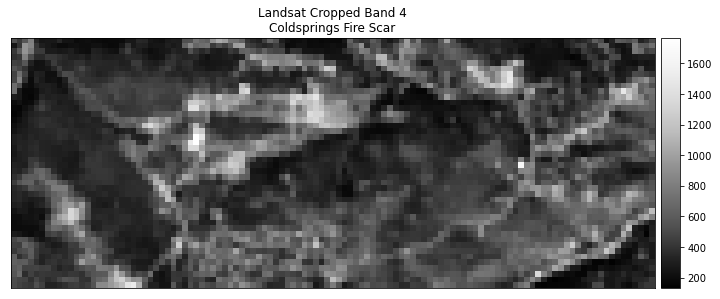

In [8]:
# Open up boundary extent in geopandas

fire_boundary_path = os.path.join("cold-springs-fire",
                                 "vector_layers",
                                 "fire-boundary-geomac",
                                 "co_cold_springs_20160711_2200_dd83.shp")

fire_boundary = gpd.read_file(fire_boundary_path)

# Open a single band an dplot
with rio.open(all_landsat_post_bands[3]) as src:
    
    # Reproject the fire boundary shapefile to be the same CRS as the LS data
    crop_raster_profile = src.profile
    fire_boundary_utmz13 = fire_boundary.to_crs(crop_raster_profile["crs"])
    
    # Crop the LS image to the extent of the fire boundary
    landsat_band4, landsat_metadata = es.crop_image(src, fire_boundary_utmz13)
    
ep.plot_bands(landsat_band4[0],
             title="Landsat Cropped Band 4\nColdsprings Fire Scar",
             scale=False)

plt.show()

### Crop a set of LS .tif files using a list of file paths (earthpy crop_all)

Above you saw how to crop a single band of data. However, often you need to crop all of your data at once. You can use the Earthpy function - cropall() to crop many files in the same CRS at once. crop_all() takes a list of geotiff file paths and crops them to the epatial extent of a shapely or geopandas object. The function returns return a list of the cropped files which you can then use the earthpy stack() function to create a stacked numpy array.

To use earthpy crop_all(), you need to:
1. define (and create) an output folder where the cropped files will be saved.
2. create a list of the paths to the tif files that you want to crop.
3. provide a crop extent layer which you will use to crop. This layer should be in the same CRS as your landsat data.

In [9]:
cropped_dir = os.path.join("cold-springs-fire",
                          "outputs",
                          "landsat_post_crop")

# Make the directory if it doesn't already exist
if not os.path.isdir(cropped_dir):
    os.mkdir(cropped_dir)
    
# Crop your data
cropped_file_list = es.crop_all(raster_paths=all_landsat_post_bands,
                               output_dir=cropped_dir,
                               geoms=fire_boundary_utmz13,
                               overwrite=True,
                               verbose=True)

# Note that because the original tif files ended with _crop you have an awkward
# output name. crop_all by default adds _crop to the end of your newly cropped files
cropped_file_list

['cold-springs-fire\\outputs\\landsat_post_crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band1_crop_crop.tif',
 'cold-springs-fire\\outputs\\landsat_post_crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band2_crop_crop.tif',
 'cold-springs-fire\\outputs\\landsat_post_crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band3_crop_crop.tif',
 'cold-springs-fire\\outputs\\landsat_post_crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band4_crop_crop.tif',
 'cold-springs-fire\\outputs\\landsat_post_crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band5_crop_crop.tif',
 'cold-springs-fire\\outputs\\landsat_post_crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band6_crop_crop.tif',
 'cold-springs-fire\\outputs\\landsat_post_crop\\LC08_L1TP_034032_20160723_20180131_01_T1_sr_band7_crop_crop.tif']

## Use Earthpy stack() to create raster stack of all LS bands in Python

Once you have a list of tif files that you wish to work with in Python, you can stack them. The earthpy es.stack() function takes 2 arguments:
1. a list of tif files that are all in the same crs and of the same extent
2. a path to a new file where the stacked raster will be saved

To call it you use the following:

es.stack(list-of-files-to-stack)

Note that this stack function was written into the Earth Lab earthpy python package to make it simpler to stack sets of remote sensing files together.

In [10]:
# This will create a new stacked raster with all bands
land_stack, land_meta = es.stack(band_paths=cropped_file_list)
land_stack

array([[[ 269,  218,  307, ...,  191,  223,  335],
        [ 148,  244,  504, ...,  348,  335,  383],
        [ 255,  291,  578, ...,  326,  319,  359],
        ...,
        [ 266,  275,  222, ...,  215,  162,  155],
        [ 275,  275,  283, ...,  238,  228,  226],
        [ 282,  264,  271, ...,  259,  286,  296]],

       [[ 327,  267,  384, ...,  216,  251,  341],
        [ 167,  295,  582, ...,  410,  384,  438],
        [ 291,  341,  654, ...,  365,  340,  382],
        ...,
        [ 320,  350,  261, ...,  242,  193,  218],
        [ 301,  312,  316, ...,  269,  270,  273],
        [ 312,  293,  288, ...,  289,  320,  342]],

       [[ 524,  433,  573, ...,  413,  409,  486],
        [ 326,  451,  827, ...,  649,  576,  646],
        [ 501,  577,  850, ...,  604,  508,  551],
        ...,
        [ 520,  576,  412, ...,  357,  321,  367],
        [ 451,  480,  484, ...,  387,  398,  423],
        [ 482,  429,  430, ...,  417,  451,  468]],

       ...,

       [[1910, 1684, 213

### Plot your raster stack

Once you have stacked your data, you can plot it or work with it as you need to.

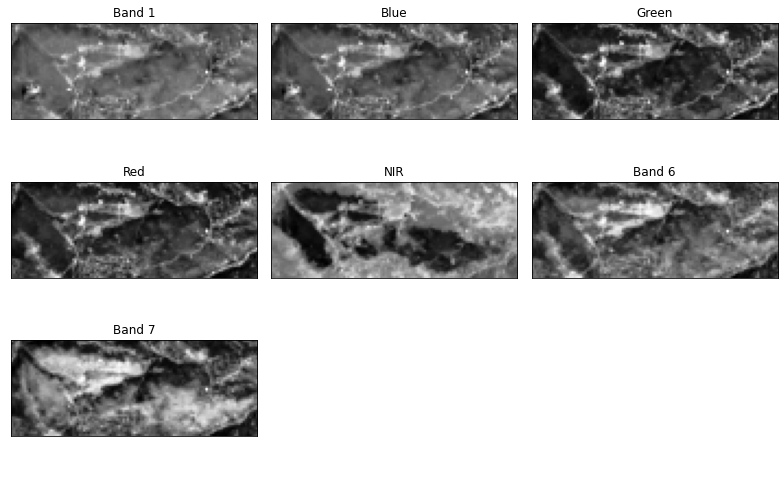

In [11]:
# Plot all bands using earthpy
band_titles = ["Band 1", "Blue", "Green", "Red",
              "NIR", "Band 6", "Band 7"]

ep.plot_bands(land_stack,
             figsize=(11, 7),
             title=band_titles,
             cbar=False)

plt.show()